Animation saved as Mac-compatible MP4: ./presentation/animation/n2d_0m3s_kappa1e_10_mu1e1_hbreg5e_3_V1e7_drainage.mp4
Animation saved as Mac-compatible MP4: ./presentation/animation/n2d_10m3s_kappa1e_10_mu1e1_hbreg5e_3_V1e7_drainage.mp4
Animation saved as Mac-compatible MP4: ./presentation/animation/n2d_100m3s_kappa1e_10_mu1e1_hbreg5e_3_V1e7_drainage.mp4


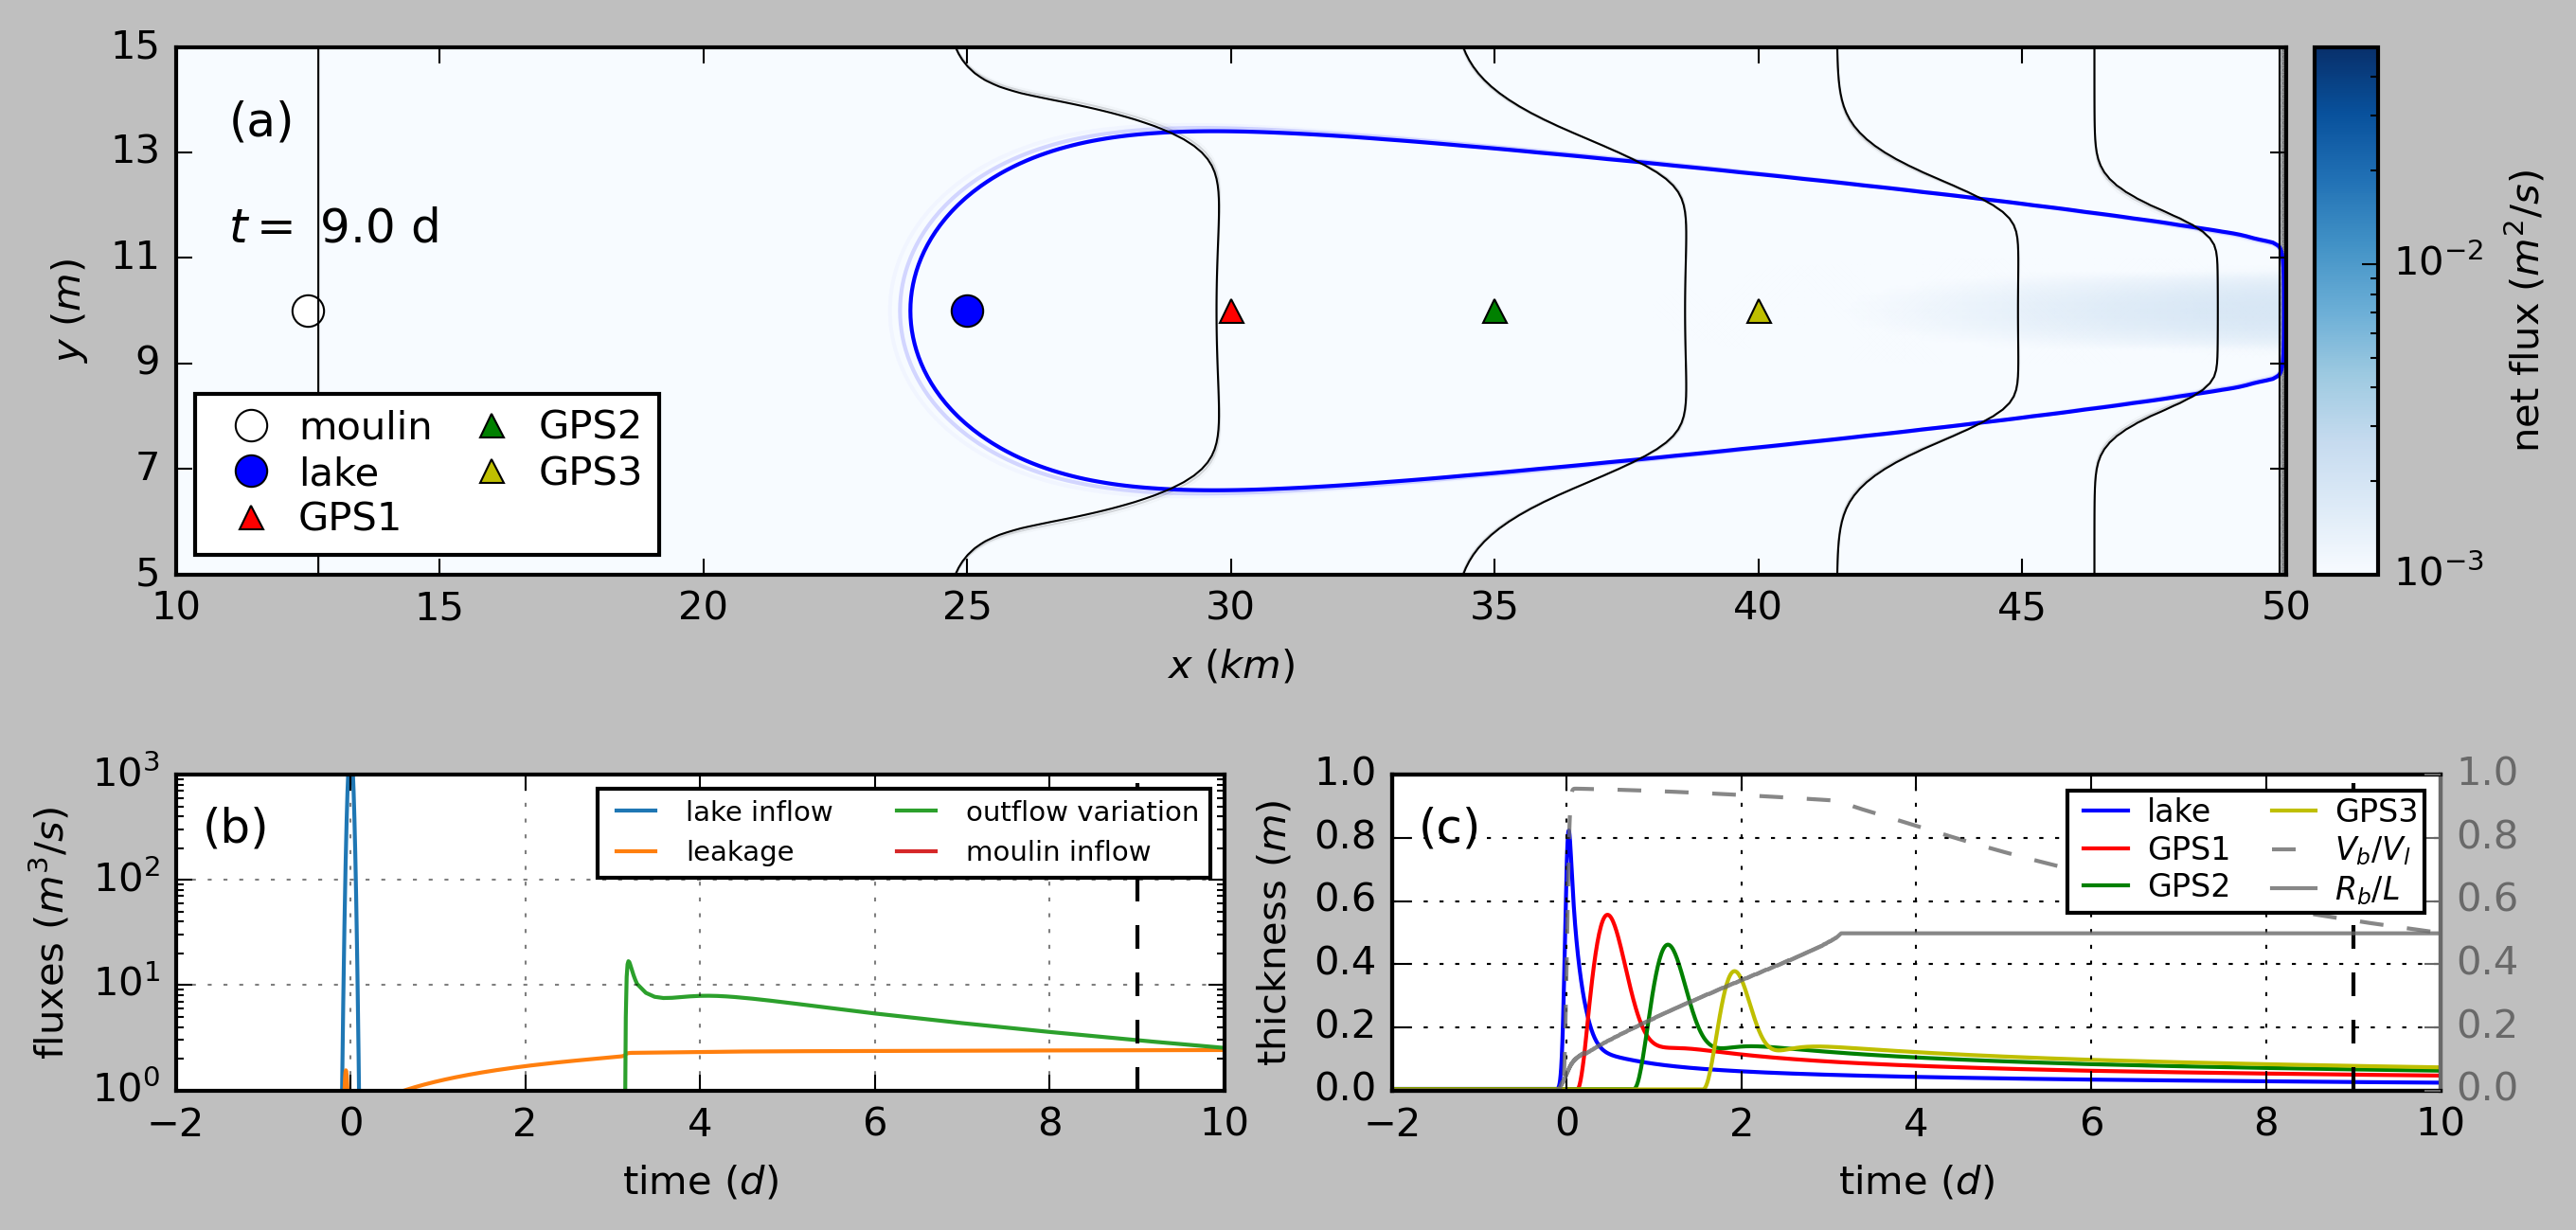

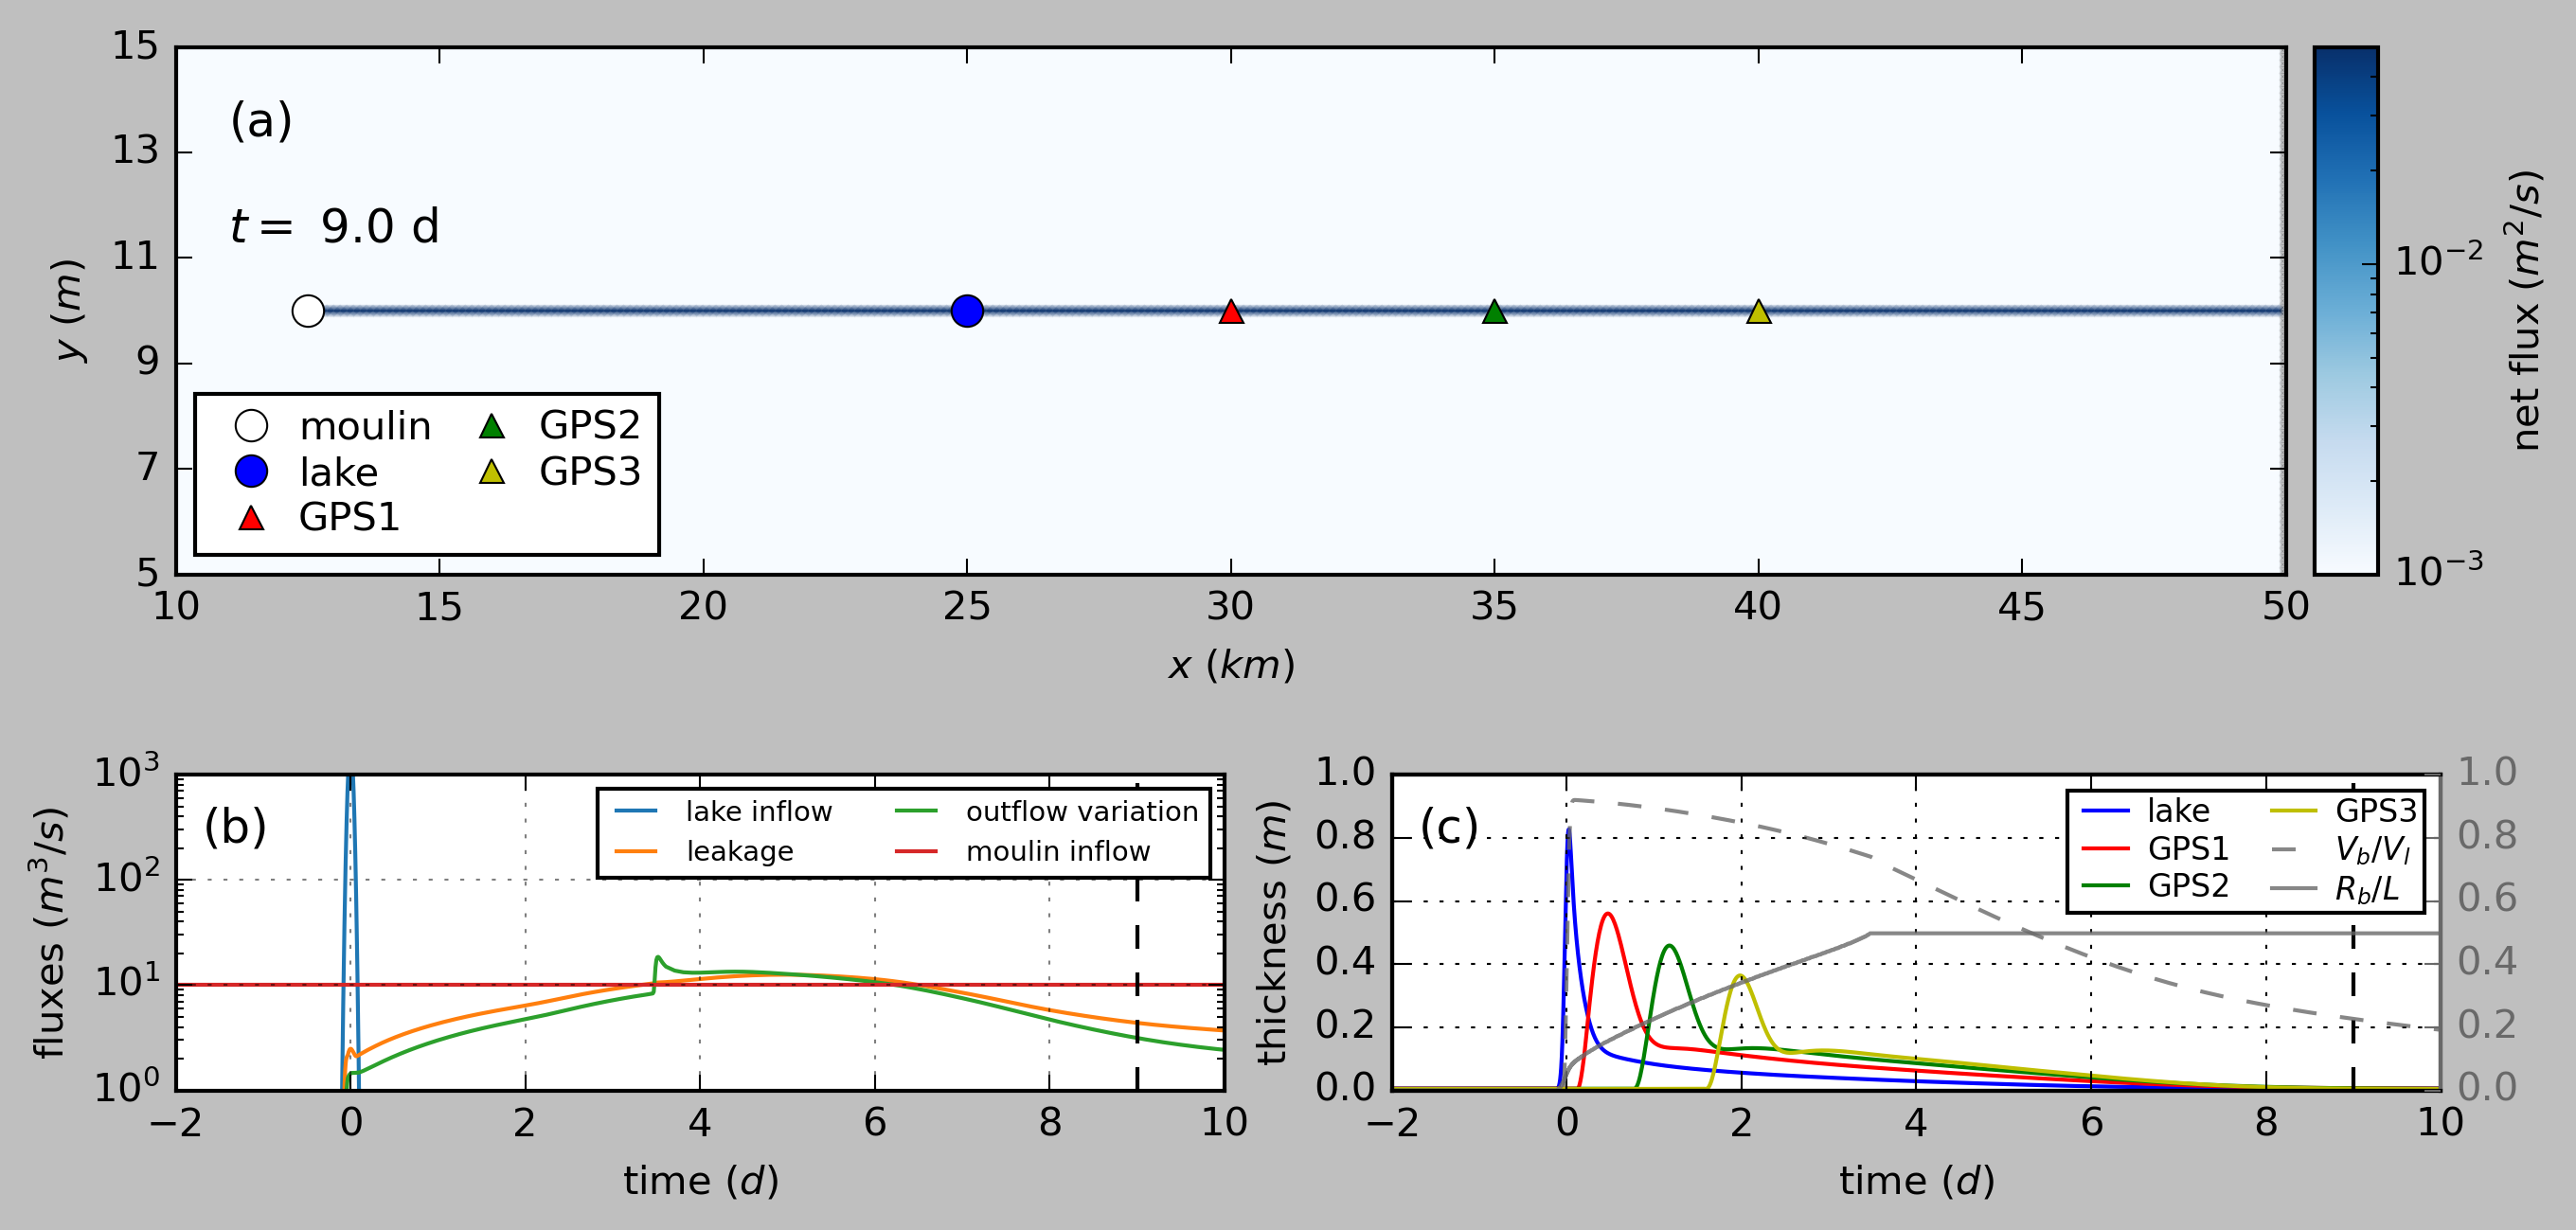

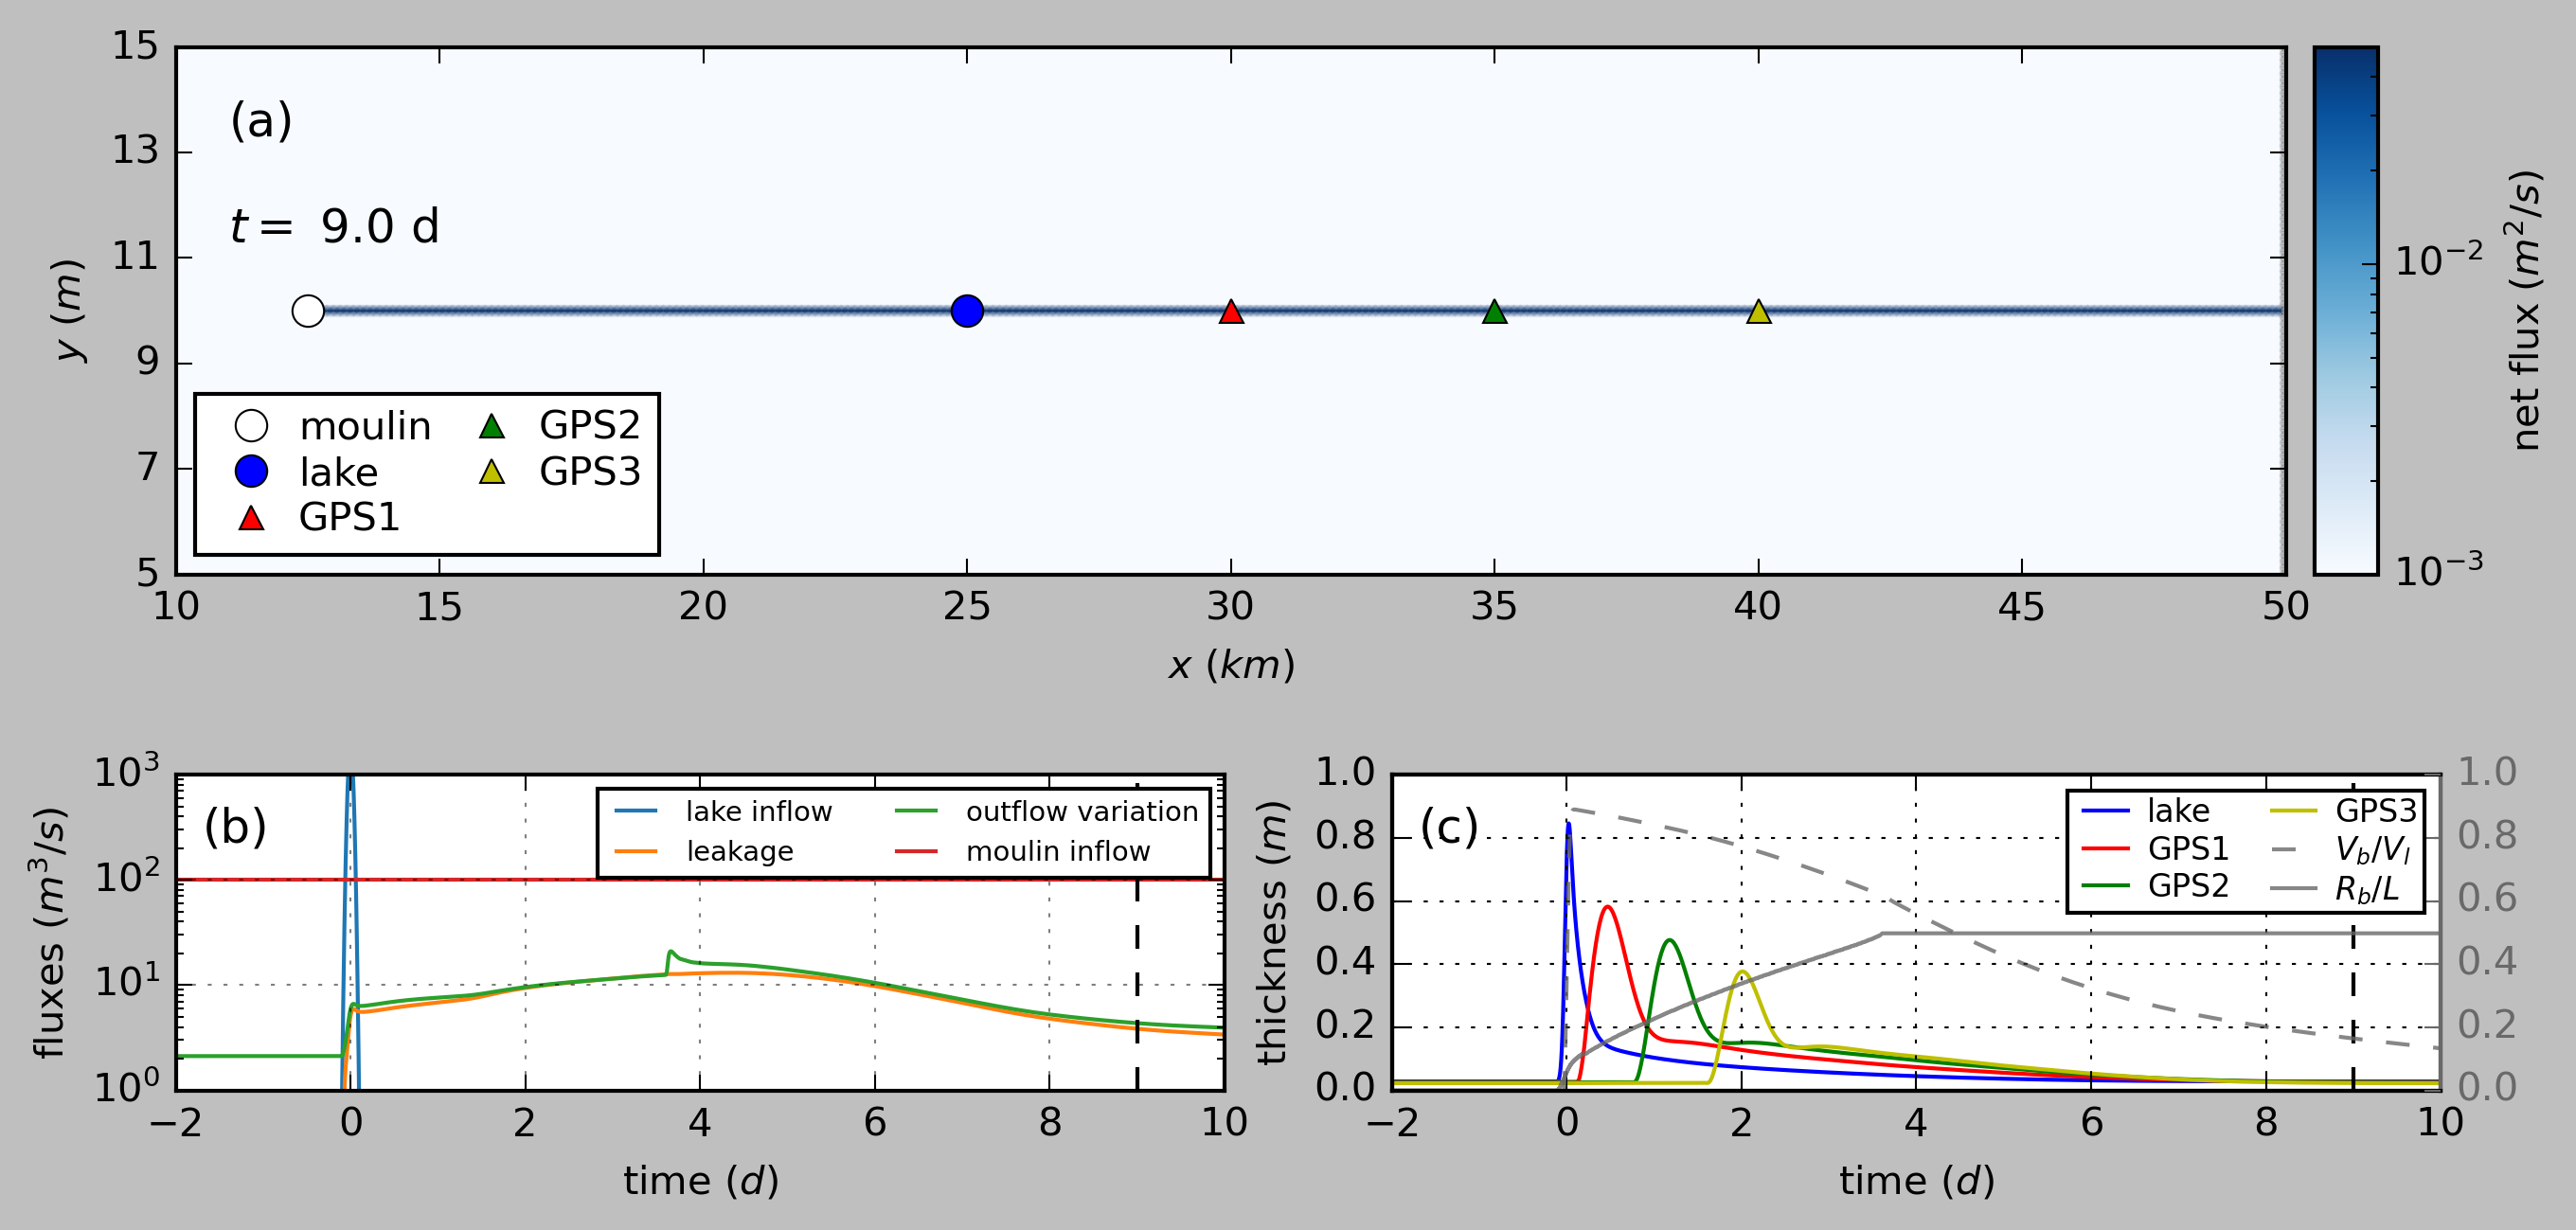

In [79]:
import os
import numpy as np
import subprocess
import scipy.io as sio
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import LogNorm
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.animation import FuncAnimation, PillowWriter
from cycler import cycler

class NevisAnimation:
    def __init__(self, casename, tslice, plot_type='qs'):
        """
        initialize the nevis animation

        parameters:
        casename: str, casename
        tslice: array-like, time slice for the animation
        plot_type: str, 'hb' or 'qs', controls whether to plot water thickness or flux
        """
        self.casename = casename
        self.tslice = tslice
        self.plot_type = plot_type
        
        # animation parameters
        self.HISTORY_STEPS = 3
        self.ALPHA_DECAY = 0.15
        
        # plotting parameters
        self.xa, self.xb = 10, 50
        self.ya, self.yb = 5, 15
        self.q_min, self.q_max = 1e-3, 5e-2
        self.h_min, self.h_max = 0, 0.1
        self.t_drainage = 750
        # initialize storage containers
        self.history_lines = []
        self.history_pcs = []

        # load data
        self._load_data()
        
    def _load_data(self):
        """load and process MATLAB data"""
        # Load main data file
        mat_path = os.path.join('results', self.casename, f'{self.casename}.mat')
        raw = sio.loadmat(mat_path, squeeze_me=True)

        # Extract key data structures
        self.tt = raw['tt']
        self.ps = raw['ps']
        self.pp = raw['pp']
        self.oo = raw['oo']
        self.pd = raw['pd']
        self.aa = raw['aa']
        self.gg = raw['gg']

        # Convert parameters to numeric types
        self._convert_parameters()

        # Compute time vectors
        self._compute_time_vectors()

        # Load spatial pattern data
        self._load_spatial_patterns()
        
    def _setup_figure(self):
        """set up figure and axes"""
        self.fig = plt.figure(figsize=(10, 5), dpi=300)
        gs = gridspec.GridSpec(3, 2, figure=self.fig, wspace=0.1, hspace=0.3)

        # set up plotting style
        plt.style.use('classic')
        colors = plt.get_cmap('tab10').colors
        plt.rc('axes', prop_cycle=cycler('color', colors))
        plt.rcParams["figure.dpi"] = 600
        plt.rcParams['font.family'] = 'DejaVu Sans'
        plt.rcParams['mathtext.fontset'] = 'dejavusans'
        plt.rcParams['font.size'] = 8

        # create subplots
        self._setup_main_panel(gs)
        self._setup_flux_panel(gs)
        self._setup_volume_panel(gs)
        
    def _update(self, frame):
        """update animation frame"""
        # update history pcolormesh
        self._update_pcolormesh_history(frame)

        # update history contours
        self._update_contour_history(frame)

        # update time labels and vertical lines
        self._update_time_indicators(frame)

        # return updated artist objects
        return self._get_artists()
        
    def create_animation(self, output_filename, fps=2):
        """create and save animation"""
        self._setup_figure()

        # create animation object
        ani = FuncAnimation(
            self.fig,
            self._update,
            frames=len(self.nums),
            init_func=self._init,
            blit=False
        )

        # save animation with Mac-compatible settings
        from matplotlib.animation import FFMpegWriter
        writer = FFMpegWriter(
            fps=fps, 
            codec='libx264', 
            bitrate=1800,
            extra_args=['-pix_fmt', 'yuv420p', '-profile:v', 'baseline', '-level', '3.0']
        )
        ani.save(output_filename, writer=writer, dpi=300)
        print(f"Animation saved as Mac-compatible MP4: {output_filename}")

        return ani
    
    def _init(self):
        """initialize animation"""
        self.history_lines = []
        self.history_pcs = []
        for collection in self.ax1.collections[1:]:
            collection.remove()
        return []

    def _update_pcolormesh_history(self, frame):
        """update pcolormesh history effect"""
        # reduce opacity of existing history
        for old_pc in self.history_pcs:
            alpha = old_pc.get_alpha() if old_pc.get_alpha() is not None else 1.0
            old_pc.set_alpha(alpha * self.ALPHA_DECAY * 2)

        # remove too old history
        while len(self.history_pcs) >= self.HISTORY_STEPS:
            old_pc = self.history_pcs.pop(0)
            old_pc.remove()

        # create new pcolormesh
        if self.plot_type == 'hb':
            new_data = (self.ps_hb * self.vhb[frame] + 
                       self.ps_h * self.vhs[frame] + 
                       self.ps_h * self.vhc[frame])
        else:
            new_data = (self.ps_qs * self.vqs[frame] + 
                       self.ps_qb * self.vqb[frame] + 
                       self.ps_qs * self.vqQ[frame])
        
        new_pc = self.ax1.pcolormesh(
            self.xx, self.yy, new_data,
            cmap=self.cmap,
            norm=self.norm,
            shading='gouraud',
            alpha=1.0
        )
        new_pc.set_edgecolor('face')
        self.history_pcs.append(new_pc)

    def _update_contour_history(self, frame):
        """update contour history effect"""
        # reduce opacity of existing history
        for contours in self.history_lines:
            for contour in contours:
                alpha = contour.get_alpha() if contour.get_alpha() is not None else 1.0
                contour.set_alpha(alpha * self.ALPHA_DECAY)

        # remove too old history
        while len(self.history_lines) >= self.HISTORY_STEPS:
            old_contours = self.history_lines.pop(0)
            for contour in old_contours:
                contour.remove()

        # create new contours
        hcontours = self.ax1.contour(
            self.xx, self.yy,
            self.ps_hb * self.vhb[frame],
            levels=[0.01],
            colors='blue',
            linewidths=1.0,
            linestyles='-'
        )
        
        phicontours = self.ax1.contour(
            self.xx, self.yy,
            self.ps_phi/1e6 * self.vphi1[frame],
            colors='k',
            linewidths=0.5,
            linestyles='-'
        )
        
        self.history_lines.append([hcontours, phicontours])
    def _convert_parameters(self):
        """Convert parameters from MATLAB data structures to numpy arrays"""
        # Convert parameters from ps structure
        self.ps_t = np.float64(self.ps['t'])
        self.pd_td = np.float64(self.pd['td'])
        self.ps_hb = np.float64(self.ps['hb'])
        self.ps_h = np.float64(self.ps['h'])
        self.ps_x = np.float64(self.ps['x'])
        self.ps_m = np.float64(self.ps['m'])
        self.ps_S = np.float64(self.ps['S'])
        self.ps_phi = np.float64(self.ps['phi'])
        self.ps_Q0 = np.float64(self.ps['Q0'])
        self.ps_Q = np.float64(self.ps['Q'])
        self.ps_qs = np.float64(self.ps['qs'])
        self.ps_qb = np.float64(self.ps['qb'])
        
        # Convert parameters from pp structure
        self.pp_c8 = np.float64(self.pp['c8'])
        
        # Convert time series data
        self.tt_t = np.float64(self.tt['t'])
        self.tt_Qb_in = np.float64(self.tt['Qb_in'])
        self.tt_Qb_dec = np.float64(self.tt['Qb_dec'])
        self.tt_Q_outb = np.float64(self.tt['Q_outb'])
        self.tt_Q_outQ = np.float64(self.tt['Q_outQ'])
        self.tt_Q_outq = np.float64(self.tt['Q_outq'])
        self.tt_E = np.float64(self.tt['E'])

        # Convert grid parameters
        self.xx = self.ps_x/1e3 * np.float64(self.gg['nx'].item())
        self.yy = self.ps_x/1e3 * np.float64(self.gg['ny'].item())
        self.nI = int(self.gg['nI'].item())
        self.nJ = int(self.gg['nJ'].item())
        self.eI = int(self.gg['eI'].item())
        self.eJ = int(self.gg['eJ'].item())
        self.cI = int(self.gg['cI'].item())
        self.cJ = int(self.gg['cJ'].item())

        # Add point data conversions
        pts_ni = np.int64(self.oo['pts_ni'].item())
        phi_0 = self.ps_phi * np.float64(self.aa['phi_0'].item())
        
        # Convert point data from time series
        self.pts_phi_lake = self.ps_phi * np.array([np.float64(sub_arr[0]) for sub_arr in self.tt['pts_phi']])
        self.pts_phi_moulin = self.ps_phi * np.array([np.float64(sub_arr[1]) for sub_arr in self.tt['pts_phi']])
        self.pts_hb_lake = self.ps_hb * np.array([np.float64(sub_arr[0]) for sub_arr in self.tt['pts_hb']])
        self.pts_hb_moulin = self.ps_hb * np.array([np.float64(sub_arr[1]) for sub_arr in self.tt['pts_hb']])
        self.pts_pb_lake = self.ps_phi * np.array([np.float64(sub_arr[0]) for sub_arr in self.tt['pts_pb']])
        self.pts_hc_lake = self.ps_h * np.array([np.float64(sub_arr[0]) for sub_arr in self.tt['pts_hc']])
        self.pts_hs_lake = self.ps_h * np.array([np.float64(sub_arr[0]) for sub_arr in self.tt['pts_hs']])

        # GPS elevations data
        self.pts_hb_gps1 = self.ps_hb * np.array([np.float64(sub_arr[2]) for sub_arr in self.tt['pts_hb']])
        self.pts_hb_gps2 = self.ps_hb * np.array([np.float64(sub_arr[3]) for sub_arr in self.tt['pts_hb']])
        self.pts_hb_gps3 = self.ps_hb * np.array([np.float64(sub_arr[4]) for sub_arr in self.tt['pts_hb']])
        self.pts_hb_gps4 = self.ps_hb * np.array([np.float64(sub_arr[5]) for sub_arr in self.tt['pts_hb']])

        self.pts_hc_gps1 = self.ps_h * np.array([np.float64(sub_arr[2]) for sub_arr in self.tt['pts_hc']])
        self.pts_hc_gps2 = self.ps_h * np.array([np.float64(sub_arr[3]) for sub_arr in self.tt['pts_hc']])
        self.pts_hc_gps3 = self.ps_h * np.array([np.float64(sub_arr[4]) for sub_arr in self.tt['pts_hc']])
        self.pts_hc_gps4 = self.ps_h * np.array([np.float64(sub_arr[5]) for sub_arr in self.tt['pts_hc']])

        self.pts_hs_gps1 = self.ps_h * np.array([np.float64(sub_arr[2]) for sub_arr in self.tt['pts_hs']])
        self.pts_hs_gps2 = self.ps_h * np.array([np.float64(sub_arr[3]) for sub_arr in self.tt['pts_hs']])
        self.pts_hs_gps3 = self.ps_h * np.array([np.float64(sub_arr[4]) for sub_arr in self.tt['pts_hs']])
        self.pts_hs_gps4 = self.ps_h * np.array([np.float64(sub_arr[5]) for sub_arr in self.tt['pts_hs']])

        # Additional derived quantities
        self.N = self.ps_phi * np.float64(self.tt['N'])  # MPa
        self.pts_N_lake = np.float64(phi_0[pts_ni][0] - self.pts_phi_lake)
        self.pts_N_moulin = np.float64(phi_0[pts_ni][1] - self.pts_phi_moulin)

        self.V_b = self.ps_x**2 * self.ps_hb * np.float64(self.tt['Vb'])
        self.V_c = self.ps_x * self.ps_S * np.float64(self.tt['S'])
        self.V_s = self.ps_x**2 * self.ps_h * np.float64(self.tt['hs'])
        self.R_b = self.ps_x * np.float64(self.tt['Rb'])

    def _compute_time_vectors(self):
        """Compute time vectors and related quantities"""
        # Compute base time vector
        self.t = (self.ps_t / (24*60*60)) * self.tt_t  # days
        
        # Compute derived quantities
        self.Q_b_in = np.float64(self.pd['Q_0']) * self.tt_Qb_in
        self.Q_b_dec = self.ps_h * self.ps_x**2 / self.ps_t * self.tt_Qb_dec
        
        self.Q_out_b = self.ps_Q0 * self.tt_Q_outb
        self.Q_out_Q = self.ps_Q * self.tt_Q_outQ
        self.Q_out_q = self.ps_Q * self.tt_Q_outq
        self.E = self.ps_m * self.ps_x**2 * self.tt_E

        # Get time points for animation
        tspan = self.ps_t/self.pd_td*self.oo['t_span']
        self.nums = np.array([np.argmin(np.abs(tspan - t_val))+1 for t_val in self.tslice])

    def _load_spatial_patterns(self):
        """Load spatial patterns for each time step"""
        # Initialize arrays
        self.vhb, self.vphi1, self.vhs = [], [], []
        self.vhc, self.vt = [], []
        self.vqs, self.vqe, self.vqQ, self.vqb = [], [], [], []

        # Get mesh operators needed for channel calculations
        nmeanx = self.gg['nmeanx'].item()
        nmeany = self.gg['nmeany'].item()
        nmeans = self.gg['nmeans'].item()
        nmeanr = self.gg['nmeanr'].item()
        Dx = np.float64(self.gg['Dx'].item())
        Dy = np.float64(self.gg['Dy'].item())
        Ds = np.float64(self.gg['Ds'].item())
        Dr = np.float64(self.gg['Dr'].item())

        # Check if ALL files have vv2
        need_preprocessing = False
        for num in self.nums:
            con_path = os.path.join('results', self.casename, f"{num:04d}.mat")
            if os.path.exists(con_path):
                raw_con = sio.loadmat(con_path, squeeze_me=True)
                if 'vv2' not in raw_con:
                    need_preprocessing = True
                    break
            else:
                need_preprocessing = True
                break

        # Run MATLAB preprocessing if needed
        if need_preprocessing:
            print("vv2 missing in some files, running MATLAB preprocessing...")
            filenames = [os.path.join('results', self.casename, f"{num:04d}.mat") for num in self.nums]
            filenames_array = np.array(filenames, dtype=object)
            sio.savemat('extend_field.mat', {
                'filenames': filenames_array,
                'casename': self.casename
            })
            matlab_path = "/Applications/MATLAB_R2025a.app/bin/matlab"
            subprocess.run([
                matlab_path,
                "-nodisplay",
                "-nosplash",
                "-nodesktop",
                "-batch",
                "nevis_nodedischarge_python"
            ], check=True)

        # Process each time step
        for num in self.nums:
            con_path = os.path.join('results', self.casename, f"{num:04d}.mat")
            raw_con = sio.loadmat(con_path, squeeze_me=True)

            vv = raw_con['vv']
            vv2 = raw_con['vv2']
            
            # Load geometry values
            phi1_val = np.float64(vv['phi'].item())
            hb_val = np.float64(vv['hb'].item())
            hs_val = np.float64(vv['hs'].item())
            
            # Calculate channel thickness - THIS WAS MISSING!
            Sx_val = nmeanx.dot(np.float64(vv['Sx'].item()))
            Sy_val = nmeany.dot(np.float64(vv['Sy'].item()))
            Ss_val = nmeans.dot(np.float64(vv['Ss'].item()))
            Sr_val = nmeanr.dot(np.float64(vv['Sr'].item()))
            hc_val = self.pp_c8*(Sx_val*Dx + Sy_val*Dy + Ss_val*Ds + Sr_val*Dr)/(Dx*Dy)
            
            # Reshape and append values
            self.vphi1.append(np.reshape(phi1_val, (self.nI, self.nJ), order='F'))
            self.vhb.append(np.reshape(hb_val, (self.nI, self.nJ), order='F'))
            self.vhs.append(np.reshape(hs_val, (self.nI, self.nJ), order='F'))
            self.vhc.append(np.reshape(hc_val, (self.nI, self.nJ), order='F'))  # ADD THIS LINE

            # Load and append flux values
            self.vqs.append(np.reshape(np.float64(vv2['qs'].item()), (self.nI, self.nJ), order='F'))
            self.vqe.append(np.reshape(np.float64(vv2['qe'].item()), (self.nI, self.nJ), order='F'))
            self.vqQ.append(np.reshape(np.float64(vv2['qQ'].item()), (self.nI, self.nJ), order='F'))
            self.vqb.append(np.reshape(np.float64(vv2['qb'].item()), (self.nI, self.nJ), order='F'))
            
            # Compute and append time values
            self.vt.append((self.ps_t / self.pd_td) * np.float64(vv['t'].item()))
        
        # Convert time list to array and adjust relative to drainage time
        self.vt = np.array(self.vt) - self.t_drainage

    def _setup_main_panel(self, gs):
        """Setup main visualization panel"""
        # Create main axes
        self.ax1 = self.fig.add_subplot(gs[0:2, 0:2])
        self.cmap = plt.cm.Blues
        
        # Add colorbar
        divider = make_axes_locatable(self.ax1)
        self.cax1 = divider.append_axes("right", size="3%", pad=0.1)
        
        # Create initial pcolormesh
        if self.plot_type == 'hb':
            data = (self.ps_hb * self.vhb[0] + 
                    self.ps_h * self.vhs[0] + 
                    self.ps_h * self.vhc[0])
            self.norm = LogNorm(vmin=self.h_min, vmax=self.h_max)
        else:
            data = (self.ps_qs * self.vqs[0] + 
                    self.ps_qb * self.vqb[0] + 
                    self.ps_qs * self.vqQ[0])
            self.norm = LogNorm(vmin=self.q_min, vmax=self.q_max)
        
        self.pc = self.ax1.pcolormesh(
            self.xx, self.yy, data,
            cmap=self.cmap,
            norm=self.norm,
            shading='gouraud'
        )
        self.pc.set_edgecolor('face')
        
        # Add colorbar
        self.cbar = self.fig.colorbar(self.pc, cax=self.cax1, orientation='vertical')
        ylabel = '$h\\;(m)$' if self.plot_type == 'hb' else 'net flux$\\;(m^2/s)$'
        self.cbar.ax.set_ylabel(ylabel, fontsize=10)
        self.cbar.ax.tick_params(labelsize=10)
        
        # Add markers
        self.ax1.plot(12.5, 10, 'wo', markersize=8, label='moulin')
        self.ax1.plot(25.0, 10, 'bo', markersize=8, label='lake')
        self.ax1.plot(30.0, 10, 'r^', markersize=6, label='GPS1')
        self.ax1.plot(35.0, 10, 'g^', markersize=6, label='GPS2')
        self.ax1.plot(40.0, 10, 'y^', markersize=6, label='GPS3')
        
        # Add text and set limits
        self.ax1.text(0.025, 0.9, '(a)', transform=self.ax1.transAxes,
                    ha='left', va='top', fontsize=12, clip_on=False)
        self.time_text = self.ax1.text(0.025, 0.7, '', transform=self.ax1.transAxes,
                                    ha='left', va='top', fontsize=12, clip_on=False)
        
        self.ax1.set_xlim(self.xa, self.xb)
        self.ax1.set_ylim(self.ya, self.yb)
        self.ax1.set_xticks(np.arange(self.xa, self.xb + 1, 5))
        self.ax1.set_yticks(np.arange(self.ya, self.yb + 1, 2))
        self.ax1.tick_params(axis='both', labelsize=10)
        self.ax1.set_xlabel('$x~(km)$',fontsize=10)
        self.ax1.set_ylabel('$y~(m)$',fontsize=10)
        self.ax1.set_aspect('equal')
        
        # Add legend
        self.ax1.legend(loc='lower left', fontsize=10, frameon=True,
                        handletextpad=0.2, ncol=2, labelspacing=0.2, numpoints=1, columnspacing=0.5)

    def _setup_flux_panel(self, gs):
        """Setup flux panel"""
        self.ax2 = self.fig.add_subplot(gs[2, 0])
        self.ax2.set_visible(False)  # Hide original axes
        # Get positions of ax2
        pos_ax2  = self.ax2.get_position()
        ax2_width = pos_ax2.x1 - pos_ax2.x0
        ax2_height = pos_ax2.y1 - pos_ax2.y0
        ax2_pos = [pos_ax2.x0, pos_ax2.y0-0.02*ax2_height, ax2_width, ax2_height]
        self.ax2 = self.fig.add_axes(ax2_pos)

        self.ax2.plot(self.t-self.t_drainage, self.Q_b_in, '-', 
                    linewidth=1.0, label='lake inflow')
        self.ax2.plot(self.t-self.t_drainage, self.Q_b_dec, '-',
                    linewidth=1.0, label='leakage')
        self.ax2.plot(self.t-self.t_drainage, 
                    self.Q_out_b + self.Q_out_Q + self.Q_out_q - self.E, '-',
                    linewidth=1.0, label='outflow variation')
        self.ax2.plot(self.t-self.t_drainage, self.E, '-',
                    linewidth=1.0, label='moulin inflow')
        
        # Add vertical time indicator
        self.ax2time = self.ax2.axvline(x=self.vt[0], color='k',
                                    linestyle='--', linewidth=1.0)
        
        self.ax2.set_yscale('log')
        self.ax2.set_xlabel(r'time $(d)$', fontsize=10)
        self.ax2.set_ylabel(r'fluxes $(m^3/s)$', fontsize=10)
        self.ax2.tick_params(axis='both', labelsize=10)
        self.ax2.set_ylim(1e0, 1e3)
        self.ax2.set_xlim(-2,10)
        
        self.ax2.text(0.025, 0.9, '(b)', transform=self.ax2.transAxes,
                    ha='left', va='top', fontsize=12)
        self.ax2.legend(loc='upper right', bbox_to_anchor=(1.0, 1.0),
                        frameon=True, fontsize=7, ncol=2)
        self.ax2.grid(alpha=0.5)

    def _setup_volume_panel(self, gs):
        """Setup volume panel"""
        self.ax3 = self.fig.add_subplot(gs[2, 1])
        self.ax3.set_visible(False)  # Hide original axes

        # Get positions of ax3
        pos_ax3  = self.ax3.get_position()
        ax3_width = pos_ax3.x1 - pos_ax3.x0
        ax3_height = pos_ax3.y1 - pos_ax3.y0
        ax3_pos = [pos_ax3.x0+0.06*ax3_width, pos_ax3.y0-0.02*ax3_height, ax3_width, ax3_height]
        self.ax3 = self.fig.add_axes(ax3_pos)
        # Plot thickness lines
        self.ax3.plot(self.t-self.t_drainage, 
                    self.ps_hb*self.pts_hb_lake + self.ps_h*(self.pts_hc_gps1+self.pts_hs_gps1),
                    'b-', linewidth=1.0, label='lake')
        self.ax3.plot(self.t-self.t_drainage,
                    self.ps_hb*self.pts_hb_gps2 + self.ps_h*(self.pts_hc_gps2+self.pts_hs_gps2),
                    'r-', linewidth=1.0, label='GPS1')
        self.ax3.plot(self.t-self.t_drainage,
                    self.ps_hb*self.pts_hb_gps3 + self.ps_h*(self.pts_hc_gps3+self.pts_hs_gps3),
                    'g-', linewidth=1.0, label='GPS2')
        self.ax3.plot(self.t-self.t_drainage,
                    self.ps_hb*self.pts_hb_gps4 + self.ps_h*(self.pts_hc_gps4+self.pts_hs_gps4),
                    'y-', linewidth=1.0, label='GPS3')

        # Add vertical time indicator
        self.ax3time = self.ax3.axvline(x=self.vt[0], color='k',
                                    linestyle='--', linewidth=1.0)
        
        self.ax3.set_xlabel(r'time $(d)$',fontsize=10)
        self.ax3.set_ylabel(r'thickness $(m)$', fontsize=10)
        self.ax3.tick_params(axis='both', labelsize=10)
        self.ax3.set_ylim(0, 1.0)
        self.ax3.set_xlim(-2, 10)
        
        self.ax3.text(0.025, 0.9, '(c)', transform=self.ax3.transAxes,
                    ha='left', va='top', fontsize=12)
        self.ax3.grid(alpha=1.0)
        
        # Add twin axis for volume
        self.ax3_twin = self.ax3.twinx()
        self.ax3_twin.plot(self.t-self.t_drainage, self.V_b/1e7, '--',
                        color='dimgray', label='$V_b/V_l$', alpha=0.8)
        self.ax3_twin.plot(self.t-self.t_drainage, self.R_b/5e4, '-',
                        color='dimgray', label='$R_b/L$', alpha=0.8)
        
        self.ax3_twin.set_ylim(0, 1.0)
        self.ax3_twin.spines['right'].set_color('dimgray')
        self.ax3_twin.yaxis.label.set_color('dimgray')
        self.ax3_twin.tick_params(axis='y', colors='dimgray')

        self.ax3_twin.set_xlabel('time $(d)$', fontsize=10)
        self.ax3_twin.set_ylim(0, 1.0)
        self.ax3_twin.tick_params(axis='y', labelsize=10)
        self.ax3_twin.grid(alpha=0.5)

        # combine legend entries from ax3 and its twin
        handles1, labels1 = self.ax3.get_legend_handles_labels()
        handles2, labels2 = self.ax3_twin.get_legend_handles_labels()
        plt.legend(handles1 + handles2, labels1 + labels2, loc='upper right',
            bbox_to_anchor=(1.00, 1.00), fontsize=8, ncol=2,
            labelspacing=0.2, handletextpad=0.3, borderpad=0.2, columnspacing=1.0,
            frameon=True, framealpha=1.0)

    def _update_time_indicators(self, frame):
        """Update time indicators on all panels"""
        self.time_text.set_text('$t=$ '+ f'${self.vt[frame]:.1f}$ d')
        self.ax2time.set_xdata([self.vt[frame], self.vt[frame]])
        self.ax3time.set_xdata([self.vt[frame], self.vt[frame]])

    def _get_artists(self):
        """Return list of artists that need updating"""
        artists = [self.time_text, self.ax2time, self.ax3time]
        artists.extend(self.history_pcs)
        for contours in self.history_lines:
            artists.extend(contours)
        return artists
    
casenames = ['n2d_0m3s_kappa1e_10_mu1e1_hbreg5e_3_V1e7_drainage',\
             'n2d_10m3s_kappa1e_10_mu1e1_hbreg5e_3_V1e7_drainage',\
             'n2d_100m3s_kappa1e_10_mu1e1_hbreg5e_3_V1e7_drainage']
# casenames = ['n2d_0m3s_kappa1e_10_mu1e1_hbreg5e_3_V1e7_drainage']
tdrainage_d = 2.0 * 365 + 20
tslice = tdrainage_d + np.arange(-1, 10, 1.0)

for casename in casenames:
    animator = NevisAnimation(casename, tslice, plot_type='qs')
    ani = animator.create_animation('./presentation/animation/'+casename+'.mp4', fps=1)

Blister outflow starts at t=66.00 days
Animation saved as Mac-compatible MP4: ./presentation/animation/n2d_region_test_meanperms1_Hreg1000_kappa1e_99_mu1e1_spinup_test.mp4


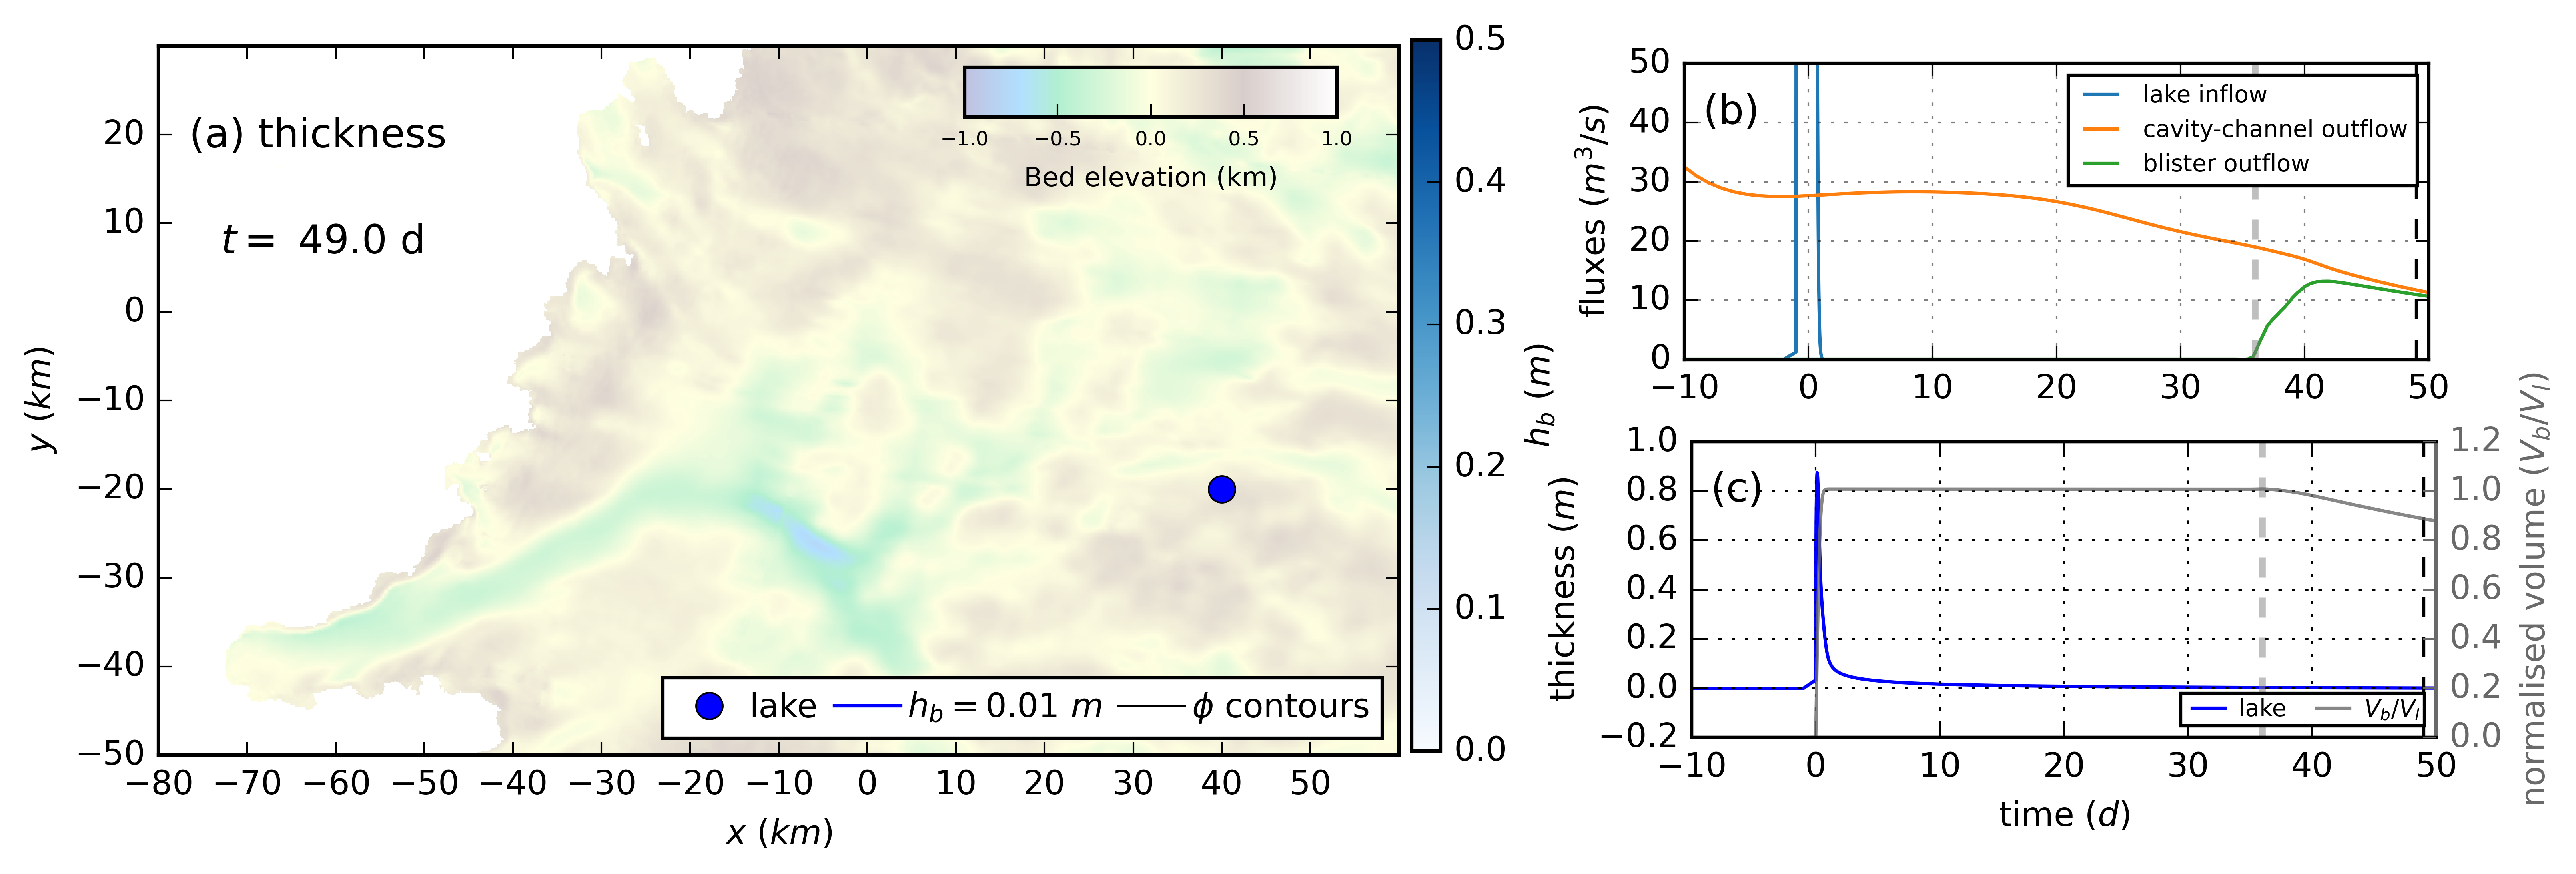

In [1]:
import os
import numpy as np
import subprocess
import scipy.io as sio
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import LogNorm
from matplotlib.colors import PowerNorm
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.animation import FuncAnimation, PillowWriter
from cycler import cycler

class NevisAnimation:
    def __init__(self, casename, tslice, plot_type='hb'):
        """
        initialize the nevis animation

        parameters:
        casename: str, casename
        tslice: array-like, time slice for the animation
        plot_type: str, 'hb' or 'qs', controls whether to plot water thickness or flux
        """
        self.casename = casename
        self.tslice = tslice
        self.plot_type = plot_type
        
        # animation parameters
        self.HISTORY_STEPS = 1
        self.ALPHA_DECAY = 0.00
        
        self.xa = -80
        self.xb = 60
        self.ya = -50
        self.yb = 30
        self.plot_hb = True
        self.plot_qs = False
        self.h_min = 0  # min water thickness on the color bar (m)
        self.h_max = 0.5  # max water thickness on the color bar (m)
        self.q_min = 0
        self.q_max = 1e-3
        # self.norm = PowerNorm(gamma=1, vmin=self.h_min, vmax=self.h_max)
        self.norm = PowerNorm(gamma=1, vmin=self.q_min, vmax=self.q_max)

        self.t_drainage = 30

        # initialize storage containers
        self.history_lines = []
        self.history_pcs = []

        # load data
        self._load_data()
        
    def _load_data(self):
        """load and process MATLAB data"""
        # Load main data file
        mat_path = os.path.join('results', self.casename, f'{self.casename}.mat')
        raw = sio.loadmat(mat_path, squeeze_me=True)

        # Extract key data structures
        self.tt = raw['tt']
        self.ps = raw['ps']
        self.pp = raw['pp']
        self.oo = raw['oo']
        self.pd = raw['pd']
        self.aa = raw['aa']
        self.gg = raw['gg']

        # Convert parameters to numeric types
        self._convert_parameters()

        # Compute time vectors
        self._compute_time_vectors()

        # Load spatial pattern data
        self._load_spatial_patterns()
        
    def _setup_figure(self):
        """set up figure and axes"""
        self.fig = plt.figure(figsize=(12, 4), dpi=600)
        gs = gridspec.GridSpec(2, 5, figure=self.fig, wspace=1.0, hspace=0.25)

        # set up plotting style
        plt.style.use('classic')
        colors = plt.get_cmap('tab10').colors
        plt.rc('axes', prop_cycle=cycler('color', colors))
        plt.rcParams["figure.dpi"] = 600
        plt.rcParams['font.family'] = 'DejaVu Sans'
        plt.rcParams['mathtext.fontset'] = 'dejavusans'
        plt.rcParams['font.size'] = 8

        # create subplots
        self._setup_main_panel(gs)
        self._setup_flux_panel(gs)
        self._setup_volume_panel(gs)
        
    def _update(self, frame):
        """update animation frame"""
        # update history pcolormesh
        self._update_pcolormesh_history(frame)

        # update history contours
        self._update_contour_history(frame)

        # update time labels and vertical lines
        self._update_time_indicators(frame)

        # return updated artist objects
        return self._get_artists()
        
    def create_animation(self, output_filename, fps=2):
        """create and save animation"""
        self._setup_figure()

        # create animation object
        ani = FuncAnimation(
            self.fig,
            self._update,
            frames=len(self.nums),
            init_func=self._init,
            blit=False
        )

        # save animation with Mac-compatible settings
        from matplotlib.animation import FFMpegWriter
        writer = FFMpegWriter(
            fps=fps, 
            codec='libx264', 
            bitrate=1800,
            extra_args=['-pix_fmt', 'yuv420p', '-profile:v', 'baseline', '-level', '3.0']
        )
        ani.save(output_filename, writer=writer, dpi=300)
        print(f"Animation saved as Mac-compatible MP4: {output_filename}")

        return ani
    
    def _init(self):
        """initialize animation"""
        self.history_lines = []
        self.history_pcs = []
        for collection in self.ax1.collections[1:]:
            collection.remove()
        return []

    def _update_pcolormesh_history(self, frame):
        """update pcolormesh history effect"""
        # reduce opacity of existing history
        for old_pc in self.history_pcs:
            alpha = old_pc.get_alpha() if old_pc.get_alpha() is not None else 1.0
            old_pc.set_alpha(alpha * self.ALPHA_DECAY * 2)

        # remove too old history
        while len(self.history_pcs) >= self.HISTORY_STEPS:
            old_pc = self.history_pcs.pop(0)
            old_pc.remove()

        # create new pcolormesh
        if self.plot_type == 'hb':
            new_data = (self.ps_hb * self.vhb[frame] + 
                       self.ps_h * self.vhs[frame] + 
                       self.ps_h * self.vhc[frame])
        else:
            new_data = (self.ps_qs * self.vqs[frame] + 
                       self.ps_qb * self.vqb[frame] + 
                       self.ps_qs * self.vqQ[frame])

        new_pc = self.ax1.pcolormesh(
            self.xx, self.yy, new_data,
            cmap=self.cmap,
            norm=self.norm,
            shading='gouraud',
            alpha=1.0, zorder=0
        )
        new_pc.set_edgecolor('face')

        # norm1 = PowerNorm(gamma=1, vmin=-1.0, vmax=1.0)
        # terrain = self.ax1.pcolormesh(self.X_terrain/1e3, self.Y_terrain/1e3, \
        #                               self.B_terrain/1e3 + 0.0*(self.S_terrain-self.B_terrain)/1e3, norm=norm1, cmap='terrain', alpha=0.3, zorder=1)

        self.history_pcs.append(new_pc)

    def _update_contour_history(self, frame):
        """update contour history effect"""
        # reduce opacity of existing history
        for contours in self.history_lines:
            for contour in contours:
                alpha = contour.get_alpha() if contour.get_alpha() is not None else 1.0
                contour.set_alpha(alpha * self.ALPHA_DECAY)

        # remove too old history
        while len(self.history_lines) >= self.HISTORY_STEPS:
            old_contours = self.history_lines.pop(0)
            for contour in old_contours:
                contour.remove()

        # create new contours
        hcontours = self.ax1.contour(
            self.xx, self.yy,
            self.ps_hb * self.vhb[frame],
            levels=[0.01],
            colors='blue',
            linewidths=1.0,
            linestyles='-'
        )
        
        phicontours = self.ax1.contour(
            self.xx, self.yy,
            self.ps_phi/1e6 * self.vphi1[frame],
            colors='k',
            linewidths=0.5,
            linestyles='-'
        )
        
        self.history_lines.append([hcontours, phicontours])
    def _convert_parameters(self):
        """Convert parameters from MATLAB data structures to numpy arrays"""
        # Convert parameters from ps structure
        self.ps_t = np.float64(self.ps['t'])
        self.pd_td = np.float64(self.pd['td'])
        self.ps_hb = np.float64(self.ps['hb'])
        self.ps_h = np.float64(self.ps['h'])
        self.ps_x = np.float64(self.ps['x'])
        self.ps_m = np.float64(self.ps['m'])
        self.ps_S = np.float64(self.ps['S'])
        self.ps_phi = np.float64(self.ps['phi'])
        self.ps_Q0 = np.float64(self.ps['Q0'])
        self.ps_Q = np.float64(self.ps['Q'])
        self.ps_qs = np.float64(self.ps['qs'])
        self.ps_qb = np.float64(self.ps['qb'])
        
        # Convert parameters from pp structure
        self.pp_c8 = np.float64(self.pp['c8'])
        
        # Convert time series data
        self.tt_t = np.float64(self.tt['t'])
        self.tt_Qb_in = np.float64(self.tt['Qb_in'])
        self.tt_Qb_dec = np.float64(self.tt['Qb_dec'])
        self.tt_Q_outb = np.float64(self.tt['Q_outb'])
        self.tt_Q_outQ = np.float64(self.tt['Q_outQ'])
        self.tt_Q_outq = np.float64(self.tt['Q_outq'])
        self.tt_E = np.float64(self.tt['E'])

        # Convert grid parameters
        self.xx = self.ps_x/1e3 * np.float64(self.gg['nx'].item())
        self.yy = self.ps_x/1e3 * np.float64(self.gg['ny'].item())
        self.nI = int(self.gg['nI'].item())
        self.nJ = int(self.gg['nJ'].item())
        self.eI = int(self.gg['eI'].item())
        self.eJ = int(self.gg['eJ'].item())
        self.cI = int(self.gg['cI'].item())
        self.cJ = int(self.gg['cJ'].item())

        # Add point data conversions
        pts_ni = np.int64(self.oo['pts_ni'].item())
        phi_0 = self.ps_phi * np.float64(self.aa['phi_0'].item())
        
        # Convert point data from time series
        self.pts_phi_lake = self.ps_phi * np.array([np.float64(sub_arr[0]) for sub_arr in self.tt['pts_phi']])
        self.pts_phi_moulin = self.ps_phi * np.array([np.float64(sub_arr[1]) for sub_arr in self.tt['pts_phi']])
        self.pts_hb_lake = self.ps_hb * np.array([np.float64(sub_arr[-1]) for sub_arr in self.tt['pts_hb']])
        self.pts_hb_moulin = self.ps_hb * np.array([np.float64(sub_arr[1]) for sub_arr in self.tt['pts_hb']])
        self.pts_pb_lake = self.ps_phi * np.array([np.float64(sub_arr[0]) for sub_arr in self.tt['pts_pb']])
        self.pts_hc_lake = self.ps_h * np.array([np.float64(sub_arr[0]) for sub_arr in self.tt['pts_hc']])
        self.pts_hs_lake = self.ps_h * np.array([np.float64(sub_arr[0]) for sub_arr in self.tt['pts_hs']])

        # GPS elevations data
        self.pts_hb_gps1 = self.ps_hb * np.array([np.float64(sub_arr[2]) for sub_arr in self.tt['pts_hb']])
        self.pts_hb_gps2 = self.ps_hb * np.array([np.float64(sub_arr[3]) for sub_arr in self.tt['pts_hb']])
        self.pts_hb_gps3 = self.ps_hb * np.array([np.float64(sub_arr[4]) for sub_arr in self.tt['pts_hb']])
        self.pts_hb_gps4 = self.ps_hb * np.array([np.float64(sub_arr[5]) for sub_arr in self.tt['pts_hb']])

        self.pts_hc_gps1 = self.ps_h * np.array([np.float64(sub_arr[2]) for sub_arr in self.tt['pts_hc']])
        self.pts_hc_gps2 = self.ps_h * np.array([np.float64(sub_arr[3]) for sub_arr in self.tt['pts_hc']])
        self.pts_hc_gps3 = self.ps_h * np.array([np.float64(sub_arr[4]) for sub_arr in self.tt['pts_hc']])
        self.pts_hc_gps4 = self.ps_h * np.array([np.float64(sub_arr[5]) for sub_arr in self.tt['pts_hc']])

        self.pts_hs_gps1 = self.ps_h * np.array([np.float64(sub_arr[2]) for sub_arr in self.tt['pts_hs']])
        self.pts_hs_gps2 = self.ps_h * np.array([np.float64(sub_arr[3]) for sub_arr in self.tt['pts_hs']])
        self.pts_hs_gps3 = self.ps_h * np.array([np.float64(sub_arr[4]) for sub_arr in self.tt['pts_hs']])
        self.pts_hs_gps4 = self.ps_h * np.array([np.float64(sub_arr[5]) for sub_arr in self.tt['pts_hs']])

        # Additional derived quantities
        self.N = self.ps_phi * np.float64(self.tt['N'])  # MPa
        self.pts_N_lake = np.float64(phi_0[pts_ni][0] - self.pts_phi_lake)
        self.pts_N_moulin = np.float64(phi_0[pts_ni][1] - self.pts_phi_moulin)

        self.V_b = self.ps_x**2 * self.ps_hb * np.float64(self.tt['Vb'])
        self.V_c = self.ps_x * self.ps_S * np.float64(self.tt['S'])
        self.V_s = self.ps_x**2 * self.ps_h * np.float64(self.tt['hs'])
        self.R_b = self.ps_x * np.float64(self.tt['Rb'])

    def _compute_time_vectors(self):
        """Compute time vectors and related quantities"""
        # Compute base time vector
        self.t = (self.ps_t / (24*60*60)) * self.tt_t  # days
        
        # Compute derived quantities
        self.Q_b_in = np.float64(self.pd['Q_0']) * self.tt_Qb_in
        self.Q_b_dec = self.ps_h * self.ps_x**2 / self.ps_t * self.tt_Qb_dec
        
        self.Q_out_b = self.ps_Q0 * self.tt_Q_outb
        self.Q_out_Q = self.ps_Q * self.tt_Q_outQ
        self.Q_out_q = self.ps_Q * self.tt_Q_outq
        self.E = self.ps_m * self.ps_x**2 * self.tt_E

        # Get time points for animation
        tspan = self.ps_t/self.pd_td*self.oo['t_span']
        self.nums = np.array([np.argmin(np.abs(tspan - t_val))+1 for t_val in self.tslice])

    def _load_spatial_patterns(self):
        """Load spatial patterns for each time step"""
        # Initialize arrays
        self.vhb, self.vphi1, self.vhs = [], [], []
        self.vhc, self.vt = [], []
        self.vqs, self.vqe, self.vqQ, self.vqb = [], [], [], []

        # Get mesh operators needed for channel calculations
        nmeanx = self.gg['nmeanx'].item()
        nmeany = self.gg['nmeany'].item()
        nmeans = self.gg['nmeans'].item()
        nmeanr = self.gg['nmeanr'].item()
        Dx = np.float64(self.gg['Dx'].item())
        Dy = np.float64(self.gg['Dy'].item())
        Ds = np.float64(self.gg['Ds'].item())
        Dr = np.float64(self.gg['Dr'].item())

        # Check if ALL files have vv2
        need_preprocessing = False
        for num in self.nums:
            con_path = os.path.join('results', self.casename, f"{num:04d}.mat")
            if os.path.exists(con_path):
                raw_con = sio.loadmat(con_path, squeeze_me=True)
                if 'vv2' not in raw_con:
                    need_preprocessing = True
                    break
            else:
                need_preprocessing = True
                break

        # Run MATLAB preprocessing if needed
        if need_preprocessing:
            print("vv2 missing in some files, running MATLAB preprocessing...")
            filenames = [os.path.join('results', self.casename, f"{num:04d}.mat") for num in self.nums]
            filenames_array = np.array(filenames, dtype=object)
            sio.savemat('extend_field.mat', {
                'filenames': filenames_array,
                'casename': self.casename
            })
            matlab_path = "/Applications/MATLAB_R2025a.app/bin/matlab"
            subprocess.run([
                matlab_path,
                "-nodisplay",
                "-nosplash",
                "-nodesktop",
                "-batch",
                "nevis_nodedischarge_python"
            ], check=True)

        mat_path = os.path.join('./data/nevis_regional/morlighem_for_nevis_140km.mat')
        raw = sio.loadmat(mat_path, squeeze_me=True)
        morlighem_for_nevis_140km = raw['morlighem_for_nevis_140km']
        self.X_terrain = morlighem_for_nevis_140km['X_km'].item()
        self.Y_terrain = morlighem_for_nevis_140km['Y_km'].item()
        self.B_terrain = morlighem_for_nevis_140km['B_km'].item()
        self.S_terrain = morlighem_for_nevis_140km['S_km'].item()

        # Process each time step
        for num in self.nums:
            con_path = os.path.join('results', self.casename, f"{num:04d}.mat")
            raw_con = sio.loadmat(con_path, squeeze_me=True)

            vv = raw_con['vv']
            vv2 = raw_con['vv2']
            
            # Load geometry values
            phi1_val = np.float64(vv['phi'].item())
            hb_val = np.float64(vv['hb'].item())
            hs_val = np.float64(vv['hs'].item())
            
            # Calculate channel thickness - THIS WAS MISSING!
            Sx_val = nmeanx.dot(np.float64(vv['Sx'].item()))
            Sy_val = nmeany.dot(np.float64(vv['Sy'].item()))
            Ss_val = nmeans.dot(np.float64(vv['Ss'].item()))
            Sr_val = nmeanr.dot(np.float64(vv['Sr'].item()))
            hc_val = self.pp_c8*(Sx_val*Dx + Sy_val*Dy + Ss_val*Ds + Sr_val*Dr)/(Dx*Dy)
            
            # Reshape and append values
            self.vphi1.append(np.reshape(phi1_val, (self.nI, self.nJ), order='F'))
            self.vhb.append(np.reshape(hb_val, (self.nI, self.nJ), order='F'))
            self.vhs.append(np.reshape(hs_val, (self.nI, self.nJ), order='F'))
            self.vhc.append(np.reshape(hc_val, (self.nI, self.nJ), order='F'))  # ADD THIS LINE

            # Load and append flux values
            self.vqs.append(np.reshape(np.float64(vv2['qs'].item()), (self.nI, self.nJ), order='F'))
            self.vqe.append(np.reshape(np.float64(vv2['qe'].item()), (self.nI, self.nJ), order='F'))
            self.vqQ.append(np.reshape(np.float64(vv2['qQ'].item()), (self.nI, self.nJ), order='F'))
            self.vqb.append(np.reshape(np.float64(vv2['qb'].item()), (self.nI, self.nJ), order='F'))
            
            # Compute and append time values
            self.vt.append((self.ps_t / self.pd_td) * np.float64(vv['t'].item()))
        
        # Convert time list to array and adjust relative to drainage time
        self.vt = np.array(self.vt) - self.t_drainage

    def _setup_main_panel(self, gs):
        """Setup main visualization panel"""
        # Create main axes
        self.ax1 = self.fig.add_subplot(gs[0:2, 0:3])
        self.cmap = plt.cm.Blues

        terrain_cmap = plt.cm.terrain  # 明确指定 terrain colormap
        terrain_norm = PowerNorm(gamma=1, vmin=-1.0, vmax=1.0)
        terrain = self.ax1.pcolormesh(self.X_terrain/1e3, self.Y_terrain/1e3, \
                                      self.B_terrain/1e3 + 0.0*(self.S_terrain-self.B_terrain)/1e3, norm=terrain_norm, cmap=terrain_cmap, alpha=0.3, zorder=1)

        from mpl_toolkits.axes_grid1.inset_locator import inset_axes
        self.cbax = inset_axes(self.ax1,
                 width="30%",   
                 height="7%",  
                 loc='lower left',
                 bbox_to_anchor=(0.65, 0.90, 1.0, 1.0),
                 bbox_transform=self.ax1.transAxes,
                 borderpad=0)
        self.cbar_terr = plt.colorbar(terrain, cax=self.cbax, orientation='horizontal')
        self.cbar_terr.set_label('Bed elevation (km)')
        self.cbar_terr.set_ticks(np.array([-1.0, -0.5, 0.0, 0.5, 1.0]))
        self.cbar_terr.ax.tick_params(labelsize=6)

        # Create initial pcolormesh
        if self.plot_type == 'hb':
            data = (self.ps_hb * self.vhb[0] + 
                    self.ps_h * self.vhs[0] + 
                    self.ps_h * self.vhc[0])
        else:
            data = (self.ps_qs * self.vqs[0] + 
                    self.ps_qb * self.vqb[0] + 
                    self.ps_qs * self.vqQ[0])
        
        self.pc = self.ax1.pcolormesh(
            self.xx, self.yy, data,
            cmap=self.cmap,
            norm=self.norm,
            shading='gouraud'
        )
        self.pc.set_edgecolor('face')
        
        # Add colorbar
        import matplotlib.cm as cm
        dummy_norm = PowerNorm(gamma=1, vmin=0, vmax=0.5)
        dummy_mappable = cm.ScalarMappable(norm=dummy_norm, cmap='Blues')
        dummy_mappable.set_array([])  # 设置空数组
        
        cax1 = self.fig.add_axes([0.56, 0.13, 0.01, 0.74])
        self.cbar = plt.colorbar(dummy_mappable, cax=cax1, orientation='vertical')
        self.cbar.ax.set_ylabel(r'$h_b$ $(m)$', fontsize=10)
        self.cbar.ax.tick_params(labelsize=10)
        
        # Add markers
        self.ax1.plot(40, -20, 'bo', markersize=8, label='lake')
        # Add an empty line to show the legend of the contours
        self.ax1.plot(1e6, 1e6, 'b-', linewidth=1.0, label=r'$h_b=0.01~m$')
        
        # Add text and set limits
        self.ax1.text(0.025, 0.9, '(a) thickness', transform=self.ax1.transAxes,
                    ha='left', va='top', fontsize=12, clip_on=False)
        self.time_text = self.ax1.text(0.05, 0.75, '', transform=self.ax1.transAxes,
                                    ha='left', va='top', fontsize=12, clip_on=False)
        
        self.ax1.set_xlim(self.xa, self.xb)
        self.ax1.set_ylim(self.ya, self.yb)
        self.ax1.set_xticks(np.arange(self.xa, self.xb, 10))
        self.ax1.set_yticks(np.arange(self.ya, self.yb, 10))
        self.ax1.tick_params(axis='both', labelsize=10)
        self.ax1.set_xlabel('$x~(km)$',fontsize=10)
        self.ax1.set_ylabel('$y~(km)$',fontsize=10)
        self.ax1.set_aspect('equal')
        
        # Add an example contour to add to legend
        self.ax1.plot([1e6], [1e6], 'k-', linewidth=0.5, label=r'$\phi$ contours')

        # Add legend
        self.ax1.legend(loc='lower right', fontsize=10, frameon=True,
                        handletextpad=0.2, ncol=3, labelspacing=0.2, numpoints=1, columnspacing=0.5)

    def _setup_flux_panel(self, gs):
        """Setup flux panel"""
        self.ax2 = self.fig.add_subplot(gs[0, 3:5])
        self.ax2.set_visible(False)  # Hide original axes

        # Get positions of ax2
        pos_ax2  = self.ax2.get_position()
        ax2_width = pos_ax2.x1 - pos_ax2.x0
        ax2_height = pos_ax2.y1 - pos_ax2.y0
        ax2_pos = [pos_ax2.x0+0.05*ax2_width, pos_ax2.y0, ax2_width, 0.9*ax2_height]
        self.ax2 = self.fig.add_axes(ax2_pos)

        self.ax2.plot(self.t-self.t_drainage, self.Q_b_in, '-', 
                    linewidth=1.0, label='lake inflow')
        # self.ax2.plot(self.t-self.t_drainage, self.Q_b_dec, '-',
        #             linewidth=1.0, label='leakage')
        self.ax2.plot(self.t-self.t_drainage, 
                    self.Q_out_Q + self.Q_out_q, '-',
                    linewidth=1.0, label='cavity-channel outflow')
        self.ax2.plot(self.t-self.t_drainage, 
                    self.Q_out_b, '-',
                    linewidth=1.0, label='blister outflow')
        # self.ax2.plot(self.t-self.t_drainage, self.E, '-',
        #             linewidth=1.0, label='moulin inflow')
        
        # Add vertical time indicator
        self.ax2time = self.ax2.axvline(x=self.vt[0], color='k',
                                    linestyle='--', linewidth=1.0)

        self.blister_out_mask = self.Q_out_b > 1
        if np.any(self.blister_out_mask):
            self.blister_out_idx = np.where(self.blister_out_mask)[0][0]  # Get first index where condition is True
            self.ax2.axvline(x=self.t[self.blister_out_idx]-self.t_drainage, color='gray', linestyle='--', linewidth=2.0, alpha=0.5)
        print(f'Blister outflow starts at t={self.t[self.blister_out_idx]:.2f} days')

        self.ax2.set_yscale('linear')
        # self.ax2.set_xlabel(r'time $(d)$', fontsize=10)
        self.ax2.set_ylabel(r'fluxes $(m^3/s)$', fontsize=10)
        self.ax2.tick_params(axis='both', labelsize=10)
        self.ax2.set_ylim(0, 5e1)
        self.ax2.set_xlim(-10,50)
        
        self.ax2.text(0.025, 0.9, '(b)', transform=self.ax2.transAxes,
                    ha='left', va='top', fontsize=12)
        self.ax2.legend(loc='upper right', bbox_to_anchor=(1.0, 1.0),
                        frameon=True, fontsize=7, ncol=1)
        self.ax2.grid(alpha=0.5)

    def _setup_volume_panel(self, gs):
        """Setup volume panel"""
        self.ax3 = self.fig.add_subplot(gs[1, 3:5])
        self.ax3.set_visible(False)  # Hide original axes

        # Get positions of ax3
        pos_ax3  = self.ax3.get_position()
        ax3_width = pos_ax3.x1 - pos_ax3.x0
        ax3_height = pos_ax3.y1 - pos_ax3.y0
        ax3_pos = [pos_ax3.x0+0.06*ax3_width, pos_ax3.y0+0.1*ax3_height, ax3_width, 0.9*ax3_height]
        self.ax3 = self.fig.add_axes(ax3_pos)
        # Plot thickness lines
        self.ax3.plot(self.t-self.t_drainage, 
                    self.ps_hb*self.pts_hb_lake,
                    'b-', linewidth=1.0, label='lake')

        # Add vertical time indicator
        self.ax3time = self.ax3.axvline(x=self.vt[0], color='k',
                                    linestyle='--', linewidth=1.0)
        
        self.ax3.axvline(x=self.t[self.blister_out_idx]-self.t_drainage, color='gray', linestyle='--', linewidth=2.0, alpha=0.5)

        self.ax3.set_xlabel(r'time $(d)$',fontsize=10)
        self.ax3.set_ylabel(r'thickness $(m)$', fontsize=10)
        self.ax3.tick_params(axis='both', labelsize=10)
        # self.ax3.set_ylim(0, 1.0)
        self.ax3.set_xlim(-10, 50)
        
        self.ax3.text(0.025, 0.9, '(c)', transform=self.ax3.transAxes,
                    ha='left', va='top', fontsize=12)
        self.ax3.grid(alpha=1.0)
        
        # Add twin axis for volume
        self.ax3_twin = self.ax3.twinx()
        self.ax3_twin.plot(self.t-self.t_drainage, self.V_b/1e8, '-',
                        color='dimgray', label='$V_b/V_l$', alpha=0.8)
        
        self.ax3_twin.set_ylim(0, 1.2)
        self.ax3_twin.set_ylabel('normalised volume $(V_b/V_l)$', color='dimgray', fontsize=10)
        self.ax3_twin.spines['right'].set_color('dimgray')
        self.ax3_twin.yaxis.label.set_color('dimgray')
        self.ax3_twin.tick_params(axis='y', colors='dimgray', labelsize=10)
        self.ax3_twin.set_xlabel('time $(d)$', fontsize=10)
        self.ax3_twin.grid(alpha=0.5)

        # combine legend entries from ax3 and its twin
        handles1, labels1 = self.ax3.get_legend_handles_labels()
        handles2, labels2 = self.ax3_twin.get_legend_handles_labels()
        plt.legend(handles1 + handles2, labels1 + labels2, loc='lower right',fontsize=7, ncol=2,
            labelspacing=0.2, handletextpad=0.3, borderpad=0.2, columnspacing=1.0,
            frameon=True, framealpha=1.0)

    def _update_time_indicators(self, frame):
        """Update time indicators on all panels"""
        self.time_text.set_text('$t=$ '+ f'${self.vt[frame]:.1f}$ d')
        self.ax2time.set_xdata([self.vt[frame], self.vt[frame]])
        self.ax3time.set_xdata([self.vt[frame], self.vt[frame]])

    def _get_artists(self):
        """Return list of artists that need updating"""
        artists = [self.time_text, self.ax2time, self.ax3time]
        artists.extend(self.history_pcs)
        for contours in self.history_lines:
            artists.extend(contours)
        return artists
    
casenames = ['n2d_region_test_meanperms1_Hreg1000_kappa1e_99_mu1e1_spinup']
tdrainage_d = 30
tslice = tdrainage_d + np.arange(-5, 50, 1.0)

for casename in casenames:
    animator = NevisAnimation(casename, tslice, plot_type='qb')
    ani = animator.create_animation('./presentation/animation/'+casename+'_test.mp4', fps=5)